# Homework 2

**The following notebook is meant to help you work through Problems 1 and 3 on Homework 2. You are by no means required to use it, nor are you required to fill out/use any of the boilerplate code/functions. You are welcome to implement the functions however you wish.**


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as c
import matplotlib.patches as mpatches
from scipy.special import expit as sigmoid
from scipy.special import softmax
from scipy.special import logsumexp

In [95]:
# loading data

# data for Problem 1
t_obs, y_obs = np.genfromtxt("data/planet-obs.csv", delimiter = ',').T
t_obs = np.split(t_obs, 10)
y_obs = np.split(y_obs.reshape(-1, 1), 10)

# data for Problem 3
data = pd.read_csv("data/hr.csv")
mapper = {
    "Dwarf": 0,
    "Giant": 1,
    "Supergiant": 2
}
data['Type'] = data['Type'].map(mapper)

X_stars = data[['Magnitude', 'Temperature']].values
y_stars = data['Type'].values

from T2_P1_TestCases import test_p1
from T2_P3_TestCases import test_p3_softmax, test_p3_knn

# Problem 1

## Problem 1 Subpart 1

In [3]:
def basis1(t):
    return np.stack([np.ones(len(t)), t], axis=1)

def basis2(t: np.ndarray):
    """
    Transform t into basis [1, t, t^2]

    :param t: a 1D numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 3)
    """
    return np.stack([np.ones(len(t)), t, np.power(t,2)], axis=1)
    #squared_col = np.stack([np.power(t,2)],axis=1)
    #return np.hstack([basis1(t),squared_col])

def basis3(t: np.ndarray):
    """
    Transform t into basis [1, t, t^2, t^3, t^4, t^5]

    :param t: a numpy array of values to transform. Shape is (n,)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 6)
    """
    return np.stack([np.ones(len(t)), t, np.power(t,2), np.power(t,3), np.power(t,4), np.power(t,5)], axis=1)
    #pow_cols = np.power(np.transpose(np.tile(t,(3,1))), [3,4,5])
    #return np.hstack([basis2(t),pow_cols])

In [4]:
from numpy import inf
rng = np.random.default_rng(seed=181)

class LogisticRegressor:
    def __init__(self, eta, runs):
        self.eta = eta
        self.runs = runs
        self.W = None

    def pred_proba (self, x: np.ndarray) -> np.ndarray:
        return sigmoid(x @ self.W)

    # see 3.13
    def logistic_loss_and_avg_gradient (self, x: np.ndarray, y: np.ndarray) -> tuple[float]:
        sigmoid_preds = self.pred_proba(x)
        loss_tmp = np.power(sigmoid_preds,y)*np.power(1-sigmoid_preds,1-y)
        logistic_loss = -np.log(loss_tmp, where=loss_tmp!=0)
        gradient = ((sigmoid_preds-y).T @ x)/np.shape(x)[0]
        return logistic_loss, gradient.T
    
    def fit(self, x, y, w_init):
        """
        Optimize the weights W to minimize the negative log-likelihood by using gradient descent

        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :param y: a 2D numpy array of output values. Shape is (n x 1)
        :param w_init: a 2D numpy array that initializes the weights. Shape is (n x 1)
        :return: None
        """
        # Keep this for the autograder
        self.W = w_init
        for _ in range(self.runs):
            loss, grad = self.logistic_loss_and_avg_gradient(x,y)
            self.W = self.W - self.eta*grad

    def predict(self, x):
        """
        Predict classification probability of transformed input x
        
        :param x: a 2D numpy array of transformed feature values. Shape is (n x 2), (n x 3), or (n x 6)
        :return: a 2D numpy array of predicted probabilities given current weights. Shape should be (n x 1)
        """
        return self.pred_proba(x)

In [5]:
test_p1(LogisticRegressor, basis1, basis2, basis3)

Your test case results are, for basis 1, 2, and 3 respectively: Pass Pass Pass


Note: Students have reported local issues with passing the basis 3 test case. Try running on Google Colab if only basis 3 test is failing.  

## Plotting Functions for Problem 1, Subpart 2

In [6]:
# Function to visualize prediction lines
# Takes as input last_x, last_y, [list of models], basis function, title
# last_x and last_y should specifically be the dataset that the last model
# in [list of models] was trained on
def visualize_prediction_lines(last_x, last_y, models, basis, title):
    # Plot setup
    green = mpatches.Patch(color='green', label='Ground truth model')
    black = mpatches.Patch(color='black', label='Mean of learned models')
    purple = mpatches.Patch(color='purple', label='Model learned from displayed dataset')
    plt.legend(handles=[green, black, purple], loc='lower right')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Observed')
    plt.axis([0, 6, -.1, 1.1]) # Plot ranges

    # Plot dataset that last model in models (models[-1]) was trained on
    cmap = c.ListedColormap(['r', 'b'])
    plt.scatter(last_x, last_y, c=last_y, cmap=cmap, linewidths=1, edgecolors='black')

    # Plot models
    X_pred = np.linspace(0, 6, 1000)
    X_pred_transformed = basis(X_pred)

    ## Ground truth model
    plt.plot(X_pred, np.cos(1.1*X_pred + 1) * 0.4 + 0.5, 'g', linewidth=5)

    ## Individual learned logistic regressor models
    Y_hats = []
    for i in range(len(models)):
        model = models[i]
        Y_hat = model.predict(X_pred_transformed)
        Y_hats.append(Y_hat)
        if i < len(models) - 1:
            plt.plot(X_pred, Y_hat, linewidth=.3)
        else:
            plt.plot(X_pred, Y_hat, 'purple', linewidth=3)

    # Mean / expectation of learned models over all datasets
    plt.plot(X_pred, np.mean(Y_hats, axis=0), 'k', linewidth=5)

    plt.savefig(title + '.png')
    plt.show()

In [7]:
# You may find it helpful to modify this function for Problem 1, Subpart 4,
# but do not change the existing code--add your own variables
def plot_results(basis, title):
    eta = 0.001
    runs = 10000

    all_models = []
    for i in range(10):
        x, y = t_obs[i], y_obs[i]
        x_transformed = basis(x)
        model = LogisticRegressor(eta=eta, runs=runs)
        model.fit(x_transformed, y, np.zeros((x_transformed.shape[1], 1)))
        all_models.append(model)

    visualize_prediction_lines(x, y, all_models, basis, title)

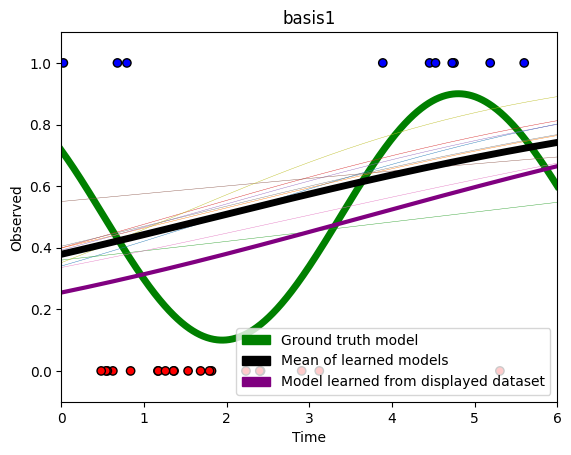

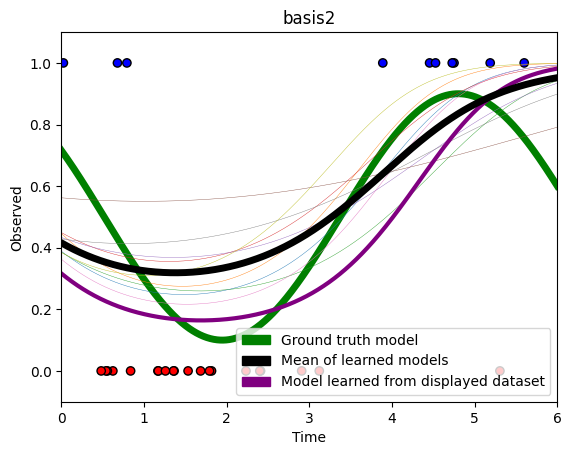

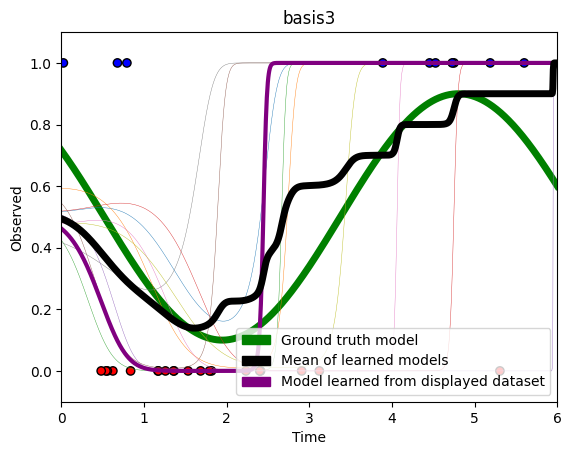

In [8]:
plot_results(basis1, 'basis1')
plot_results(basis2, 'basis2')
plot_results(basis3, 'basis3')

# Problem 3

In [10]:
import scipy.stats

def onehot (y: np.ndarray) -> np.ndarray:
    """
    one-hot encode 1D array of class memberships.
    
    :param y: a 1D numpy array of target values (Dwarf=0, Giant=1, Supergiant=2).
    :return: y, onehot encoded
    """
    oh = np.zeros((y.size, y.max() + 1))
    oh[np.arange(y.size), y] = 1
    return oh

In [11]:
class GaussianGenerativeModel:
    def __init__(self, is_shared_covariance=False):
        self.is_shared_covariance = is_shared_covariance
        self.class_covariance_matrices = None
        self.priors = None
        self.means = None

    # posterior propto likelihood * prior

    def fit(self, X, y):
        """
        Compute the means and (shared) covariance matrix of the data. Compute the prior over y.
        
        :param X: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :param y: a 1D numpy array of target values (Dwarf=0, Giant=1, Supergiant=2).
        :return: None
        """
        # calculate MLE for prior
        # calculate MLE for means- TODO revisit
        # if shared cov matrix
            # calculate MLE for shared cov matrix using (2)
        # else
            # calculate MLE for shared cov matrix (prob cant use summation or smth)

        y_oh = onehot(y)
        # class membership numbers
        memb = np.sum(y_oh,axis=0)
        # datapoints
        N = np.shape(X)[0]
        D = np.shape(X)[1]
        # classes
        K = np.shape(y_oh)[1]
        self.priors = memb/N
        print(np.shape(self.priors))

        self.means = np.zeros(shape=(K,np.shape(X)[1]))

        print()
        for k in range(K):
            for n in range(N):
                self.means[k] += y_oh[n][k] * X[n]
        self.means = 1/memb[:,np.newaxis] * self.means
        print("MEANS DONE")
        print(self.means)
        
        cm = np.zeros(shape=(D,D))
        # initialize
        self.class_covariance_matrices = np.zeros(shape=(K,D,D))
        for k in range(K):
            for n in range(N):
                cm = cm + y_oh[n][k] * (X[n] - self.means[k])[:,np.newaxis] @ (X[n] - self.means[k])[np.newaxis,:]
            if not self.is_shared_covariance:
                print(memb)
                self.class_covariance_matrices[k] = 1/memb[k] * cm
                # if shared we want to continue the summation, else we reset
                cm = np.zeros(shape=(D,D))
        if self.is_shared_covariance:
            cm = 1/N * cm
            self.class_covariance_matrices = np.broadcast_to(cm,(K,D,D))
        return

    def predict(self, X_pred):
        """
        The code in this method should be removed and replaced! We included it
        just so that the distribution code is runnable and produces a
        (currently meaningless) visualization.
        
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """
        # compute NLL for each class
        # posterior = prior * NLL
        # choose class w/ highest posterior
        return np.argmin(self.negative_log_likelihood(X_pred) * self.priors,axis=1)
            

    def negative_log_likelihood(self, X):
        """
        Given the data X, use previously calculated class means and covariance matrix to 
        calculate the negative log likelihood of the data
        """
        # memb = np.sum(y_oh,axis=0)
        # datapoints
        N = np.shape(X)[0]
        K = np.size(self.priors)
        log_likelihood = np.zeros((N,K))
        for n in range(N):
            for k in range(K):
                dist = scipy.stats.multivariate_normal(self.means[k], self.class_covariance_matrices[k])
                log_likelihood[n][k] = dist.logpdf(X[n])

        return -log_likelihood

In [24]:
class SoftmaxRegression:
    def __init__(self, eta, lam, runs = 200000):
        self.eta = eta
        self.lam = lam
        self.W = None
        self.runs = max(runs,200000)

    def fit(self, X, y):
        """
        Fit the weights W of softmax regression using gradient descent with L2 regularization
        Use the results from Problem 2 to find an expression for the gradient
        
        :param X: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :param y: a 1D numpy array of target values (Dwarf=0, Giant=1, Supergiant=2).
        :return: None
        """
        # Initializing the weights (do not change!)
        # The number of classes is 1 + (the highest numbered class)
        X = np.hstack([np.ones((1,np.shape(X)[0])).T,X])
        print(np.shape(X))
        num_classes = 1 + y.max()
        num_features = X.shape[1]
        self.W = np.ones((num_classes, num_features))
        for _ in range(self.runs):
            loss, grad = self.loss_and_grad(X,y)
            self.W = self.W - self.eta*grad

    def predict(self, X_pred):
        """
        The code in this method should be removed and replaced! We included it
        just so that the distribution code is runnable and produces a
        (currently meaningless) visualization.
        
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """
        X_pred = np.hstack([np.ones((1,np.shape(X_pred)[0])).T,X_pred])
        print(self.W)
        return np.argmax(self.predict_proba(X_pred).T,axis=0)
    
    def loss_and_grad(self, X, y):
        softmax_preds = self.predict_proba(X)
        y_oh = onehot(y)
        # For reference
        """
        loss_tmp = np.power(sigmoid_preds,y)*np.power(1-sigmoid_preds,1-y)
        logistic_loss = -np.log(loss_tmp, where=loss_tmp!=0)
        """
        cross_entropy_error =  -np.sum(y_oh @ np.log(softmax_preds, where=softmax_preds>0).T)
        gradient = (softmax_preds - y_oh).T @ X + (self.lam)*(self.W)
        return cross_entropy_error, gradient
    
    def predict_proba(self, X_pred):
        """    
        Predict classification probabilities of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 2D numpy array of predicted class probabilities (Dwarf=index 0, Giant=index 1, Supergiant=index 2).
                 Shape should be (n x 3)
        """
        # TODO
        # (3 x 2) @ (n x 2) -> T -> (n x 3)
        #X_pred = np.hstack([np.ones((1,np.shape(X_pred)[0])).T,X_pred])
        return softmax(X_pred @ self.W.T, axis=1)

In [194]:
from scipy.stats import mode

class KNNClassifier:
    def __init__(self, k):
        self.X = None
        self.y = None
        self.K = k
        
    def map_to_class (self, i: int):
        """
        retrieve index `i` from classes
        """
        return self.y[i]

    def distance(self, p1, p2):
        d = (p1[0] - p2[0])**2 / 9 +(p1[1] - p2[1])**2
        return  d
    
    def fit(self, X, y):
        """
        In KNN, "fitting" can be as simple as storing the data, so this has been written for you.
        If you'd like to add some preprocessing here without changing the inputs, feel free,
        but this is completely optional.
        """
        self.X = X
        self.y = y

    def predict(self, X_pred):
        """ 
        Predict classes of points given feature values in X_pred
        
        :param X_pred: a 2D numpy array of (transformed) feature values. Shape is (n x 2)
        :return: a 1D numpy array of predicted classes (Dwarf=0, Giant=1, Supergiant=2).
                 Shape should be (n,)
        """
        dists = scipy.spatial.distance.cdist(X_pred, self.X, metric=self.distance)
        dists_indices_sorted = np.argsort(dists,axis=1)
        k_nearest = dists_indices_sorted[:,0:self.K]
        k_nearest_classes = self.map_to_class(k_nearest)
        maj_votes = mode(k_nearest_classes,axis=1)[0]
        return maj_votes

In [116]:
def phi(X):
    """
    Transform [x_1, x_2] into basis [ln(x_1 + 10), x_2^2]

    :param t: a 2D numpy array of values to transform. Shape is (n x 2)
    :return: a 2D array in which each row corresponds to a basis transformation of
             an input value. Shape should be (n x 2)
    """
    transformed_basis = np.copy(X)
    transformed_basis[:,0] = np.log(transformed_basis[:,0] + 10)
    transformed_basis[:,1] = transformed_basis[:,1]**2
    print(np.shape(transformed_basis))
    
    return transformed_basis

## Plotting Function for Problem 3, Subpart 1

In [144]:
# Visualize the decision boundary that a model produces
def visualize_boundary(model, X, y, title, basis=None, width=2):
    # Create a grid of points
    x_min, x_max = min(X[:, 0] - width), max(X[:, 0] + width)
    y_min, y_max = min(X[:, 1] - width), max(X[:, 1] + width)
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, 0.05),
        np.arange(y_min, y_max, 0.05)
    )

    # Flatten the grid so the values match spec for self.predict
    xx_flat = xx.flatten()
    yy_flat = yy.flatten()
    X_pred = np.vstack((xx_flat, yy_flat)).T
    print(np.shape(X_pred))
    
    if basis is not None:
        X_pred = basis(X_pred)
    print(np.shape(X_pred))

    # Get the class predictions
    Y_hat = model.predict(X_pred)
    Y_hat = Y_hat.reshape((xx.shape[0], xx.shape[1]))

    # Visualize them.
    cmap = c.ListedColormap(['r', 'b', 'g'])
    plt.figure()
    plt.title(title)
    plt.xlabel('Magnitude')
    plt.ylabel('Temperature')
    plt.pcolormesh(xx, yy, Y_hat, cmap=cmap, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, linewidths=1,
                edgecolors='black')

    # Adding a legend and a title
    red = mpatches.Patch(color='red', label='Dwarf')
    blue = mpatches.Patch(color='blue', label='Giant')
    green = mpatches.Patch(color='green', label='Supergiant')
    plt.legend(handles=[red, blue, green])

    # Saving the image to a file, and showing it as well
    plt.savefig(title + '.png')
    plt.show()

## Problem 3, Subpart 1

(3,)

MEANS DONE
[[ 3.16923077  0.49461538]
 [ 0.15        1.23833333]
 [-5.7         0.84875   ]]


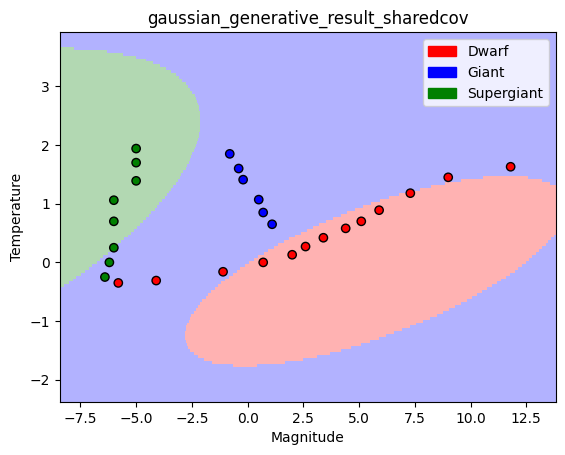

In [207]:
gg_model_shared = GaussianGenerativeModel(is_shared_covariance=True)
gg_model_shared.fit(X_stars, y_stars)
visualize_boundary(model=gg_model_shared,
                   X=X_stars,
                   y=y_stars,
                   title='gaussian_generative_result_sharedcov',
                   basis=None)

(3,)

MEANS DONE
[[ 3.16923077  0.49461538]
 [ 0.15        1.23833333]
 [-5.7         0.84875   ]]
[13.  6.  8.]
[13.  6.  8.]
[13.  6.  8.]


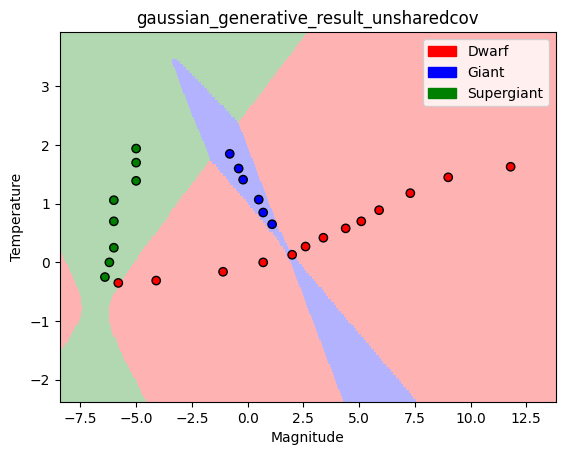

In [208]:
gg_model_unshared = GaussianGenerativeModel(is_shared_covariance=False)
gg_model_unshared.fit(X_stars, y_stars)
visualize_boundary(model=gg_model_unshared,
                   X=X_stars,
                   y=y_stars,
                   title='gaussian_generative_result_unsharedcov',
                   basis=None)

(27, 3)
(56070, 2)
(56070, 2)
[[ 12.15017629   3.47210612 -15.42828769]
 [  1.39298188   0.77670128   7.24822137]
 [-11.08696616  -1.79261539  10.63625833]]


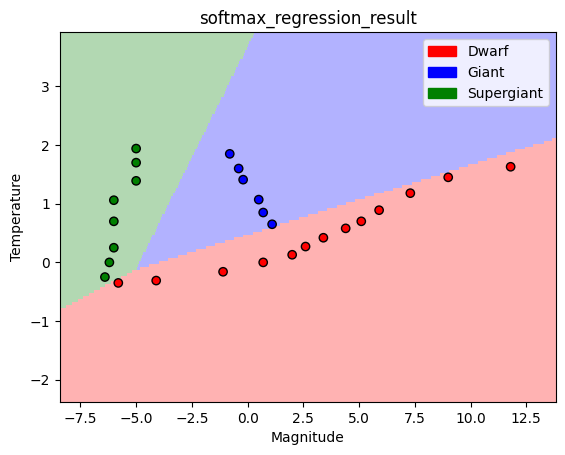

In [25]:
# Example of fitting a model and visualizing the decision boundaries;
# do this for each of the four models
softmax_model = SoftmaxRegression(eta=0.001, lam=0.001)
softmax_model.fit(X_stars, y_stars)
visualize_boundary(model=softmax_model,
                   X=X_stars,
                   y=y_stars,
                   title='softmax_regression_result',
                   basis=None)

(27, 2)
(27, 3)
(56070, 2)
(56070, 2)
(56070, 2)
[[-8.92385352  7.42722582 -0.98134517]
 [-5.27856831  4.90931462  0.55637611]
 [16.65861384 -9.88034843  2.88116108]]


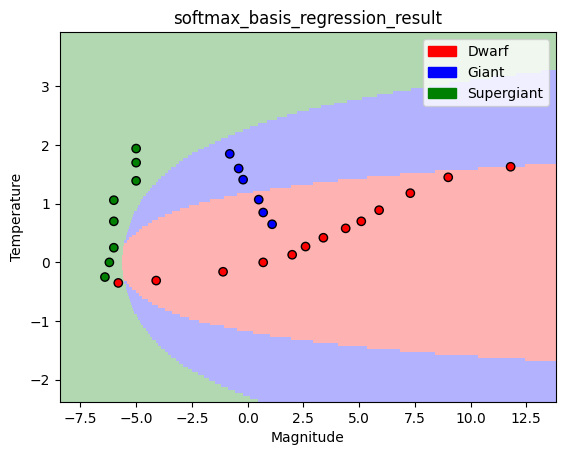

In [128]:
basis_model = SoftmaxRegression(eta=0.001, lam=0.001)
basis_model.fit(phi(X_stars), y_stars)
visualize_boundary(model=basis_model,
                   X=X_stars,
                   y=y_stars,
                   title='softmax_basis_regression_result',
                   basis=phi)

(56070, 2)
(56070, 2)


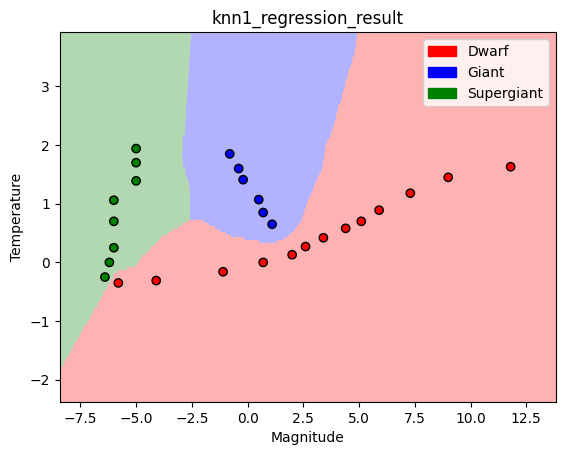

In [176]:
# Example of fitting a model and visualizing the decision boundaries;
# do this for each of the four models
knn1_model = KNNClassifier(k=1)
knn1_model.fit(X_stars, y_stars)
visualize_boundary(model=knn1_model,
                   X=X_stars,
                   y=y_stars,
                   title='knn1_regression_result',
                   basis=None)

(56070, 2)
(56070, 2)


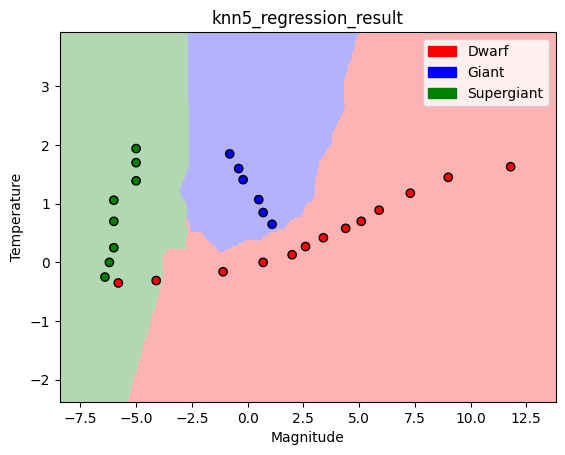

In [192]:
# Example of fitting a model and visualizing the decision boundaries;
# do this for each of the four models
knn5_model = KNNClassifier(k=5)
knn5_model.fit(X_stars, y_stars)
visualize_boundary(model=knn5_model,
                   X=X_stars,
                   y=y_stars,
                   title='knn5_regression_result',
                   basis=None)

In [193]:
# test your models by passing your fitted models into the functions below
# softmax_model is an instance of class SoftmaxRegression fitted to data X_stars, y_stars
# basis_model is an instance of class SoftmaxRegression fitted to data phi(X_stars), y_stars
# knn1_model is an instance of class KNNClassifier with parameter k=1
# knn5_model is an instance of class KNNClassifier with parameter k=5
test_p3_softmax(softmax_model, basis_model)
test_p3_knn(knn1_model, knn5_model)

Passed softmax regression tests
Passed KNN tests
